In [1]:
# library
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchmetrics import R2Score

r2score = R2Score()

torch.manual_seed(1)
np.random.seed(1)
torch.set_printoptions(precision=4)

In [2]:
# Hyperparameters
p = 8   # size of branch and trunk ouput
n = 4   # horizon window length
H = 51  # maximum window length

In [3]:
# Model
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    
    # Branch x0
    self.input_x0  = torch.nn.Linear(1, 8)
    self.hidden_x0 = torch.nn.Linear(8, 8)
    self.output_x0 = torch.nn.Linear(8, p)

    # Branch 1 u
    self.input1_u  = torch.nn.Linear(n, 2)
    self.hidden1_u = torch.nn.Linear(2, 2)
    self.output1_u = torch.nn.Linear(2, 2)

    # Branch 2 u
    self.input2_u  = torch.nn.Linear(n, 2)
    self.hidden2_u = torch.nn.Linear(2, 2)
    self.output2_u = torch.nn.Linear(2, 2)

    # Branch 3 u
    self.input3_u  = torch.nn.Linear(n, 2)
    self.hidden3_u = torch.nn.Linear(2, 2)
    self.output3_u = torch.nn.Linear(2, 2)

    # Branch 4 u
    self.input4_u  = torch.nn.Linear(n, 2)
    self.hidden4_u = torch.nn.Linear(2, 2)
    self.output4_u = torch.nn.Linear(2, 2)

    # Trunk
    self.input_t   = torch.nn.Linear(1, 8)
    self.hidden_t  = torch.nn.Linear(8, 8)
    self.output_t  = torch.nn.Linear(8, p)

  def forward(self, x0, u, t):
    h = torch.relu(self.input_x0(x0))
    h = torch.relu(self.hidden_x0(h))
    h = self.output_x0(h)

    f1 = torch.relu(self.input1_u(u))
    f1 = torch.relu(self.hidden1_u(f1))
    f1 = self.output1_u(f1)

    f2 = torch.relu(self.input2_u(u))
    f2 = torch.relu(self.hidden2_u(f2))
    f2 = self.output2_u(f2)

    f3 = torch.relu(self.input3_u(u))
    f3 = torch.relu(self.hidden3_u(f3))
    f3 = self.output3_u(f3)

    f4 = torch.relu(self.input4_u(u))
    f4 = torch.relu(self.hidden4_u(f4))
    f4 = self.output4_u(f4)

    f = torch.cat((f1, f2, f3, f4), dim=1)
    
    g = torch.relu(self.input_t(t))
    g = torch.relu(self.hidden_t(g))
    g = self.output_t(g)

    return torch.sum(h*f*g + x0, dim=1).reshape(-1,1)

In [4]:
# Model error
def eval(model, testset):
    with torch.no_grad():
        pred_Y = model(testset.x0_data, testset.u_data, testset.t_data)

    r2 = r2score(pred_Y, testset.y_data)
    return r2.item()

In [5]:
# Create network
device = torch.device("cpu")
net = Net().to(device)

In [6]:
# Data
class Data(torch.utils.data.Dataset):
  def __init__(self, src_file):
    df = pd.read_csv(src_file, header=None)

    X0, U, T, Y = np.array([[1]], dtype=np.float32), np.ones((1, n)), np.array([[1]], dtype=np.float32), np.array([[1]], dtype=np.float32)

    for i in range(df.shape[0]):
        row = np.array(df.iloc[i])
        for j in range(H-n):
            x0 = np.array([[row[H+j]]])
            u  = np.array([row[j:j+n]])
            for t in range(1, n+1):
                y = np.array([[row[H+j+t]]])
                t = np.array([[t]])

                X0 = np.concatenate((X0, x0))
                U  = np.concatenate((U, u))
                T  = np.concatenate((T, t))
                Y  = np.concatenate((Y, y))

    X0, U, T, Y = X0[1:], U[1:], T[1:], Y[1:]

    self.x0_data = torch.tensor(X0, dtype=torch.float32)
    self.u_data  = torch.tensor(U, dtype=torch.float32)
    self.t_data  = torch.tensor(T, dtype=torch.float32)
    self.y_data  = torch.tensor(Y, dtype=torch.float32)

  def __len__(self):
    return len(self.x0_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    x0  = self.x0_data[idx]
    u   = self.u_data[idx]
    t   = self.t_data[idx]
    y   = self.y_data[idx]
    sample = {'x0':x0, 'u':u, 't':t, 'y':y}
    return sample

# Create Dataset and DataLoader objects
src_file_train = 'C:/Users/tln229/Downloads/Python/2. DeepONets/0. Data/data_6.csv'
train_ds       = Data(src_file_train)

src_file_test = 'C:/Users/tln229/Downloads/Python/2. DeepONets/0. Data/data_7.csv'
test_ds       = Data(src_file_test)

In [7]:
# Early stopping
def early_stop(list, min_epochs, patience):
    if(len(list) > min_epochs):
        if(np.max(list[-patience:]) < 1.001*np.max(list[0: -patience])):
            return 1
    return 0

In [8]:
# train model
max_epochs = 5000
loss_func  = torch.nn.MSELoss()
optimizer  = torch.optim.Adam(net.parameters(), lr=0.001)

train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=train_ds.y_data.shape[0], shuffle=True)

R2_train = np.array([])
R2_test  = np.array([])
for epoch in range(0, max_epochs+1):
    net.train()
    loss  = 0
    count = 0
    for (_, batch) in enumerate(train_ldr):
        X0 = batch['x0']
        U  = batch['u']
        T  = batch['t']
        Y  = batch['y']

        optimizer.zero_grad()
        output = net(X0, U, T)             # compute the output of the Network
        loss_val = loss_func(output, Y)    # loss function
        loss += loss_val.item()            # accumulate
        loss_val.backward()                # gradients
        optimizer.step()                   # update paramters
        count += 1
    
    net.eval()
    R2_train = np.append(R2_train, eval(net, train_ds))
    R2_test  = np.append(R2_test, eval(net, test_ds))

    if(epoch%10==0):
        print("epoch = %5d \t loss = %9.5f \t R2_train = %9.5f \t R2_test = %9.5f" % (epoch, loss/count, eval(net, train_ds), eval(net, test_ds)))
    
    if(early_stop(list = R2_train, min_epochs = 500, patience = 200) == 1):
        break

epoch =     0 	 loss =  40.23405 	 R2_train = -20.41874 	 R2_test = -36.31787
epoch =    10 	 loss =  39.97219 	 R2_train = -20.27681 	 R2_test = -36.07837
epoch =    20 	 loss =  39.64321 	 R2_train = -20.09632 	 R2_test = -35.77994
epoch =    30 	 loss =  39.17410 	 R2_train = -19.83568 	 R2_test = -35.34905
epoch =    40 	 loss =  38.43395 	 R2_train = -19.42200 	 R2_test = -34.65617
epoch =    50 	 loss =  37.23695 	 R2_train = -18.75325 	 R2_test = -33.51406
epoch =    60 	 loss =  35.32624 	 R2_train = -17.68831 	 R2_test = -31.68081
epoch =    70 	 loss =  32.37761 	 R2_train = -16.05280 	 R2_test = -28.86682
epoch =    80 	 loss =  28.10547 	 R2_train = -13.70289 	 R2_test = -24.84294
epoch =    90 	 loss =  22.54623 	 R2_train = -10.68680 	 R2_test = -19.68883
epoch =   100 	 loss =  16.39177 	 R2_train =  -7.41381 	 R2_test = -14.04463
epoch =   110 	 loss =  11.14885 	 R2_train =  -4.72026 	 R2_test =  -9.20191
epoch =   120 	 loss =   7.98727 	 R2_train =  -3.13252 	 R2_tes

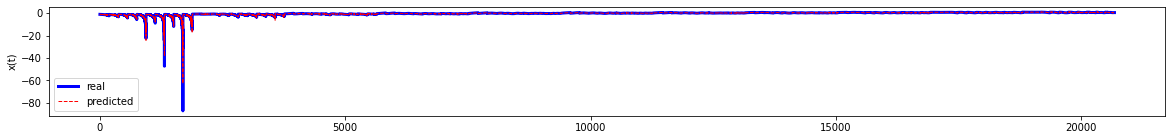

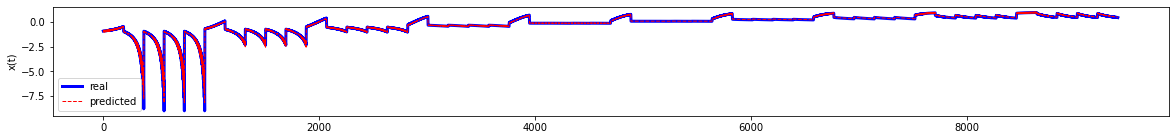

In [9]:
def plot(dataset, size):
    with torch.no_grad():
        pred_Y = net(dataset.x0_data, dataset.u_data, dataset.t_data)

    plt.figure(figsize=size)
    plt.plot(dataset.y_data, 'b',   label=r'real',      linewidth=3)
    plt.plot(pred_Y,         'r--', label=r'predicted', linewidth=1)
    plt.ylabel(r'x(t)')
    plt.legend()
    plt.show()

plot(train_ds, (20,2))
plot(test_ds, (20,2))

In [10]:
print(np.argmax(R2_test))
print(np.max(R2_test))

4969
0.9969202876091003


In [11]:
PATH = 'C:/Users/tln229/Downloads/Python/2. DeepONets/0. Saved models/Stacked.pt'
torch.save(net, PATH)